In [1]:
import sys
sys.path.append("../Python")
import ROOT as R
import time
import numpy as np
# Turn jsroot off if you want to make a pdf from this file.
%jsroot off
from root_helpers import SetStyle
from root_helpers import fancy_plot
from root_helpers import print_mc_particle_tree
from root_helpers import print_daughters
R.EnableImplicitMT()
import os
recompile = True
try:
    if os.path.getmtime('../Python/Utility_Functions_C.so') - os.path.getmtime('../Python/Utility_Functions.C') > 0:
        recompile = False
        print("Recompile is not needed")
    else:
        print("Recompiling: ")
except:
    print("Recompile needed, file not found.")
if recompile:
    R.gROOT.LoadMacro("../Python/Utility_Functions.C++")
else:
    R.gSystem.Load("../Python/Utility_Functions_C.so")
R.Utility_Functions()

R.gSystem.Load("/data/HPS/lib/libMiniDST")
R.gSystem.Load("/data/HPS/Analysis/lib/libEcal_Analysis")
R.gInterpreter.ProcessLine('''auto EAC = Ecal_Analysis_Class();''')   # This is key. It puts the EAC in C++ space.
print(f"{R.EAC.Version()}")

Welcome to JupyROOT 6.29/01
Recompile is not needed
V1.0.9


In [2]:
ch = R.TChain("MiniDST")
ch.Add(f"/data/HPS/data/MC/emumu_calchep/eventsHPS_*_recon.root")
print(f"Chain N events loaded:  {ch.GetEntries()/1e6:7.3f}M")
df = R.RDataFrame(ch)
print("Available data names in Tuple:")
ColumnNames=df.GetColumnNames()
ll = 0
pr_colnames = [x for x in ColumnNames if str(x).startswith('')]
for nn in pr_colnames:
    if ll < len(nn):
        ll = len(nn)+2
for n in range(len(pr_colnames)):
    if n%4 == 0:
        print("")
    print(f"{str(pr_colnames[n]):{ll}s}",end="")

Chain N events loaded:    6.874M
Available data names in Tuple:

ecal_cluster_energy             ecal_cluster_hits               ecal_cluster_mc_id              ecal_cluster_mc_pdg             
ecal_cluster_mc_pdg_purity      ecal_cluster_nhits              ecal_cluster_seed_energy        ecal_cluster_seed_index         
ecal_cluster_seed_ix            ecal_cluster_seed_iy            ecal_cluster_time               ecal_cluster_uncor_energy       
ecal_cluster_uncor_hits         ecal_cluster_uncor_nhits        ecal_cluster_uncor_seed_energy  ecal_cluster_uncor_seed_index   
ecal_cluster_uncor_seed_ix      ecal_cluster_uncor_seed_iy      ecal_cluster_uncor_time         ecal_cluster_uncor_x            
ecal_cluster_uncor_y            ecal_cluster_uncor_z            ecal_cluster_x                  ecal_cluster_y                  
ecal_cluster_z                  ecal_hit_energy                 ecal_hit_index_x                ecal_hit_index_y                
ecal_hit_mc_contrib_ec          

In [3]:
ECAL_template = (50,-25.5,24.5,13,-6.5,6.5)
hh1 = None
hh2 = None
hh3 = None
hh4 = None
hh5 = None
hh6 = None
hh7 = None
hh8 = None

In [4]:
df = df\
    .Define("imum","RVec<int> out; for(int i=0; i< ecal_cluster_mc_pdg.size(); ++i){ if(ecal_cluster_mc_pdg[i]==13){out.push_back(i);}} return out;")\
    .Define("imup","RVec<int> out; for(int i=0; i< ecal_cluster_mc_pdg.size(); ++i){ if(ecal_cluster_mc_pdg[i]==-13){out.push_back(i);}} return out;")\
    .Define("iel","RVec<int> out; for(int i=0; i< ecal_cluster_mc_pdg.size(); ++i){ if(ecal_cluster_mc_pdg[i]==11){out.push_back(i);}} return out;")\
    .Define("ix_mum","RVec<int> out; for(int i=0; i< imum.size(); ++i){out.push_back(ecal_cluster_seed_ix[imum[i]]);} return out;")\
    .Define("iy_mum","RVec<int> out; for(int i=0; i< imum.size(); ++i){out.push_back(ecal_cluster_seed_iy[imum[i]]);} return out;")\
    .Define("ix_mup","RVec<int> out; for(int i=0; i< imup.size(); ++i){out.push_back(ecal_cluster_seed_ix[imup[i]]);} return out;")\
    .Define("iy_mup","RVec<int> out; for(int i=0; i< imup.size(); ++i){out.push_back(ecal_cluster_seed_iy[imup[i]]);} return out;")\
    .Define("ecal_1hit","RVec<int> out; for(int i=0; i< ecal_cluster_nhits.size(); ++i){if(ecal_cluster_nhits[i]==1){out.push_back(i);}} return out;")\
    .Define("ecal_muons","""
    vector< pair<int,int> > out;
    for(int i=0; i< ecal_1hit.size(); ++i) for(int j=i+1; j< ecal_1hit.size(); ++j){
     if(ecal_cluster_energy[i]< 0.45 && ecal_cluster_energy[j]< 0.45 &&
        TMath::Sign(1, ecal_cluster_seed_ix[i])== -TMath::Sign(1,ecal_cluster_seed_ix[j]) &&
        TMath::Sign(1, ecal_cluster_seed_iy[i])== -TMath::Sign(1,ecal_cluster_seed_iy[j]) ){ out.push_back(make_pair(i,j));}}
    return out;""")

In [5]:
hh_ecal_hits = df.Histo2D(("hh_ecal_hits","Ecal Hits;ix;iy")+ECAL_template,"ecal_hit_index_x","ecal_hit_index_y")
hh_ecal_seed = df.Histo2D(("hh_ecal_seed_hits","Ecal Seed Hits;ix;iy")+ECAL_template,"ecal_cluster_seed_ix","ecal_cluster_seed_iy")
hh_ecal_seed_mum = df.Histo2D(("hh_ecal_seed_hits_mum","Ecal Seed Hits mu-;ix;iy")+ECAL_template,"ix_mum","iy_mum")
hh_ecal_seed_mup = df.Histo2D(("hh_ecal_seed_hits_mup","Ecal Seed Hits mu+;ix;iy")+ECAL_template,"ix_mup","iy_mup")
hh_ecal_seed_mup_cut1 = df.Filter("return ((imum.size()==1) && (ix_mum[0]<0) && (iy_mum[0]>0))").Histo2D(("hh_ecal_seed_hits_mup_cut1","Ecal Seed Hits mu+, when mu- in top left;ix;iy")+ECAL_template,"ix_mup","iy_mup")
hh_ecal_seed_mup_cut2 = df.Filter("return ((imum.size()==1) && (ix_mum[0]<0) && (iy_mum[0]<0))").Histo2D(("hh_ecal_seed_hits_mup_cut2","Ecal Seed Hits mu+, when mu- in bottom left;ix;iy")+ECAL_template,"ix_mup","iy_mup")
hh_ecal_seed_mup_cut3 = df.Filter("return ((imum.size()==1) && (ix_mum[0]>0) && (iy_mum[0]>0))").Histo2D(("hh_ecal_seed_hits_mup_cut2","Ecal Seed Hits mu+, when mu- in top right;ix;iy")+ECAL_template,"ix_mup","iy_mup")
hh_ecal_seed_mup_cut4 = df.Filter("return ((imum.size()==1) && (ix_mum[0]>0) && (iy_mum[0]<0))").Histo2D(("hh_ecal_seed_hits_mup_cut2","Ecal Seed Hits mu+, when mu- in bottom right;ix;iy")+ECAL_template,"ix_mup","iy_mup")


hh_clus_e = df.Histo1D(("hh_clus_e","Ecal Cluster Energy;E[GeV]",1000,-0.,5.),"ecal_cluster_energy")
hh_clus_e_e = df.Define("e_e","RVec<double> out; for(int i=0; i<ecal_cluster_energy.size(); ++i){ if(ecal_cluster_mc_pdg[i]==11){out.push_back(ecal_cluster_energy[i]);}} return out;").Histo1D(("hh_clus_e_e","Ecal Cluster Energy e-;E[GeV]",1000,-0.,5.),"e_e")
hh_clus_e_mum = df.Define("e_e","RVec<double> out; for(int i=0; i<ecal_cluster_energy.size(); ++i){ if(ecal_cluster_mc_pdg[i]==13){out.push_back(ecal_cluster_energy[i]);}} return out;").Histo1D(("hh_clus_e_mum","Ecal Cluster Energy mu-;E[GeV]",1000,-0.,5.),"e_e")
hh_clus_e_mup = df.Define("e_e","RVec<double> out; for(int i=0; i<ecal_cluster_energy.size(); ++i){ if(ecal_cluster_mc_pdg[i]==-13){out.push_back(ecal_cluster_energy[i]);}} return out;").Histo1D(("hh_clus_e_mup","Ecal Cluster Energy mu+;E[GeV]",1000,-0.,5.),"e_e")

hh_clus_e_1h = df.Define("e_e","RVec<double> out; for(int i=0; i<ecal_cluster_energy.size(); ++i){ if(ecal_cluster_nhits[i]==1){out.push_back(ecal_cluster_energy[i]);}} return out;").Histo1D(("hh_clus_e_1h","1 Hit Ecal Cluster Energy;E[GeV]",1000,-0.,5.),"e_e")
hh_clus_e_1h_e = df.Define("e_e","RVec<double> out; for(int i=0; i<ecal_cluster_energy.size(); ++i){ if(ecal_cluster_nhits[i]==1 && ecal_cluster_mc_pdg[i]==11){out.push_back(ecal_cluster_energy[i]);}} return out;").Histo1D(("hh_clus_e_1h_e","1 Hit Ecal Cluster Energy e-;E[GeV]",1000,-0.,5.),"e_e")
hh_clus_e_1h_mum = df.Define("e_e","RVec<double> out; for(int i=0; i<ecal_cluster_energy.size(); ++i){ if(ecal_cluster_nhits[i]==1 && ecal_cluster_mc_pdg[i]==13){out.push_back(ecal_cluster_energy[i]);}} return out;").Histo1D(("hh_clus_e_1h_mum","1 Hit Ecal Cluster Energy mu-;E[GeV]",1000,-0.,5.),"e_e")
hh_clus_e_1h_mup = df.Define("e_e","RVec<double> out; for(int i=0; i<ecal_cluster_energy.size(); ++i){ if(ecal_cluster_nhits[i]==1 && ecal_cluster_mc_pdg[i]==-13){out.push_back(ecal_cluster_energy[i]);}} return out;").Histo1D(("hh_clus_e_1h_mup","1 Hit Ecal Cluster Energy mu+;E[GeV]",1000,-0.,5.),"e_e")

hh_clus_pdg = df.Histo1D(("hh_clus_pdg","Ecal Cluster MC primary pdg;pdg id",41,-15.5,25.5),"ecal_cluster_mc_pdg")
hh_hit_contrib_pdg = df.Define("pdg","RVec<int> out; for(int i=0;i<ecal_hit_mc_contrib_pdg.size();++i){for(int j=0;j<ecal_hit_mc_contrib_pdg[i].size();++j){out.push_back(ecal_hit_mc_contrib_pdg[i][j]);}} return out;").Histo1D(("hh_hit_contrib_pdg","Ecal Hit MC pdg;pdg id",41,-15.5,25.5),"pdg")
hh_hit_parent_pdg = df.Histo1D(("hh_hit_parent_pdg","Ecal Hit MC parent pdg;pdg id",41,-15.5,25.5),"ecal_hit_mc_parent_pdg")
hh_mc_part_pdg = df.Histo1D(("hh_mc_part_pdg","MC particle pdg;pdg id",41,-15.5,25.5),"mc_part_pdg")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc0_1
Info in <TCanvas::Print>: pdf file All_seed_hit_location.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc0_2
Info in <TCanvas::Print>: pdf file Muon_minus_seed_hit_location.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc0_3
Info in <TCanvas::Print>: pdf file Muon_plus_seed_hit_location.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc0_4
Info in <TCanvas::Print>: pdf file Muon_minus_top_left_seed_hit_location.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc0_5
Info in <TCanvas::Print>: pdf file Muon_minus_bot_left_seed_hit_location.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc0_6
Info in <TCanvas::Print>: pdf file Muon_minus_top_right_seed_hit_location.pdf has been created
Warning in <TCanvas::Constructor

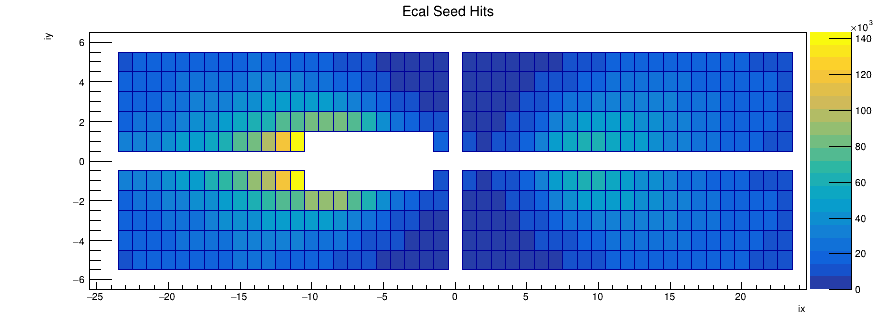

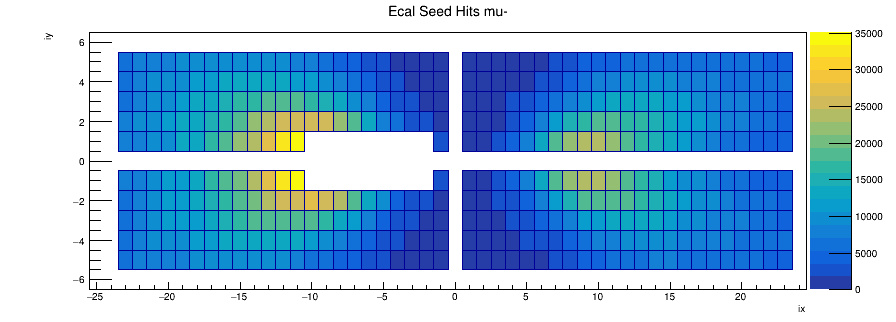

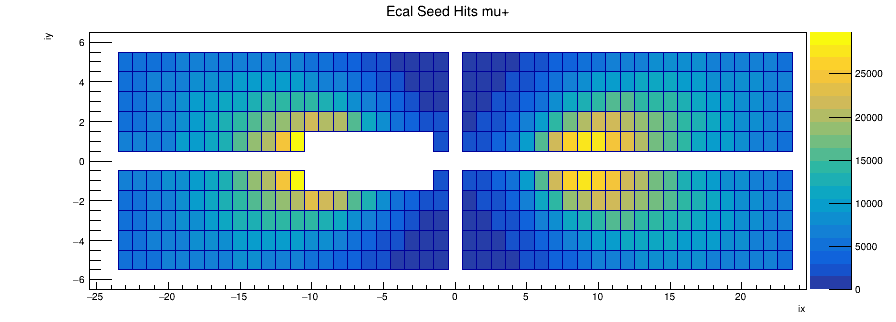

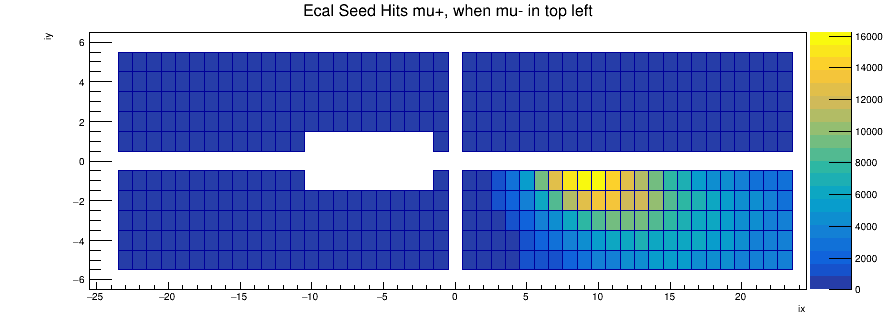

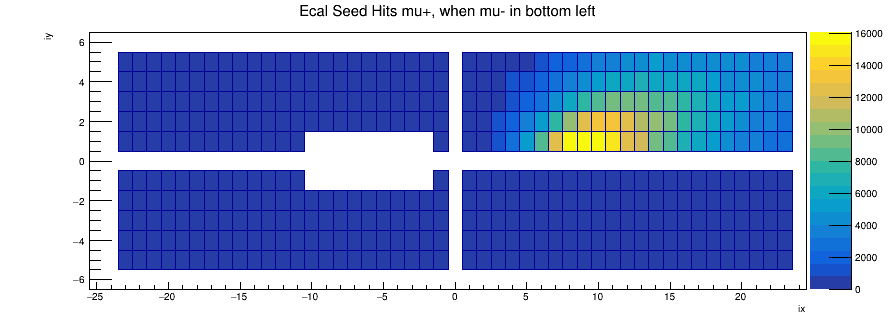

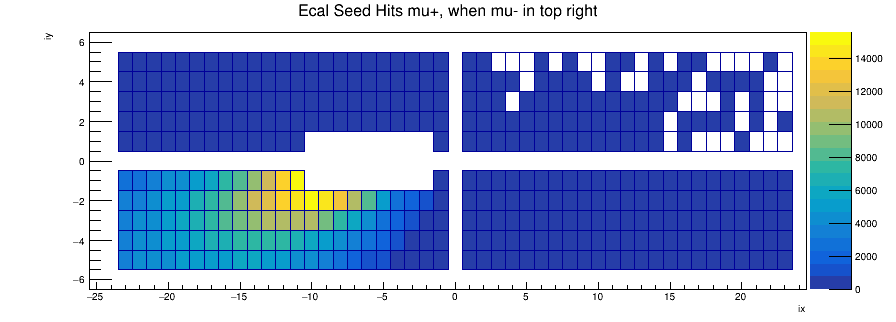

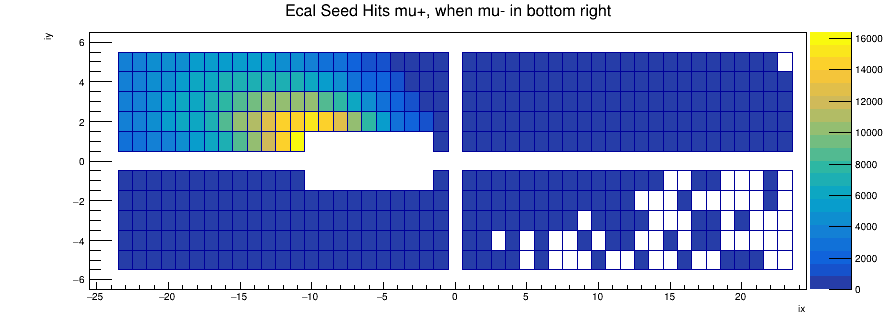

In [7]:
cc0_1 = R.TCanvas("cc0_1","CC0_1",900,350)
hh1 = fancy_plot(hh_ecal_seed, hh1, 0x0)
cc0_1.SaveAs("All_seed_hit_location.pdf")
cc0_1.Draw()
cc0_2 = R.TCanvas("cc0_2","CC0_2",900,350)
hh2 = fancy_plot(hh_ecal_seed_mum, hh2, 0x0)
cc0_2.SaveAs("Muon_minus_seed_hit_location.pdf")
cc0_2.Draw()
cc0_3 = R.TCanvas("cc0_3","CC0_3",900,350)
hh3 = fancy_plot(hh_ecal_seed_mup, hh3, 0x0)
cc0_3.SaveAs("Muon_plus_seed_hit_location.pdf")
cc0_3.Draw()
cc0_4 = R.TCanvas("cc0_4","CC0_4",900,350)
hh4 = fancy_plot(hh_ecal_seed_mup_cut1, hh4, 0x0)
cc0_4.SaveAs("Muon_minus_top_left_seed_hit_location.pdf")
cc0_4.Draw()
cc0_5 = R.TCanvas("cc0_5","CC0_5",900,350)
hh5 = fancy_plot(hh_ecal_seed_mup_cut2, hh5, 0x0)
cc0_5.SaveAs("Muon_minus_bot_left_seed_hit_location.pdf")
cc0_5.Draw()
cc0_6 = R.TCanvas("cc0_6","CC0_6",900,350)
hh6 = fancy_plot(hh_ecal_seed_mup_cut3, hh6, 0x0)
cc0_6.SaveAs("Muon_minus_top_right_seed_hit_location.pdf")
cc0_6.Draw()
cc0_7 = R.TCanvas("cc0_7","CC0_7",900,350)
hh7 = fancy_plot(hh_ecal_seed_mup_cut4, hh7, 0x0)
cc0_7.SaveAs("Muon_minus_bot_right_seed_hit_location.pdf")
cc0_7.Draw()

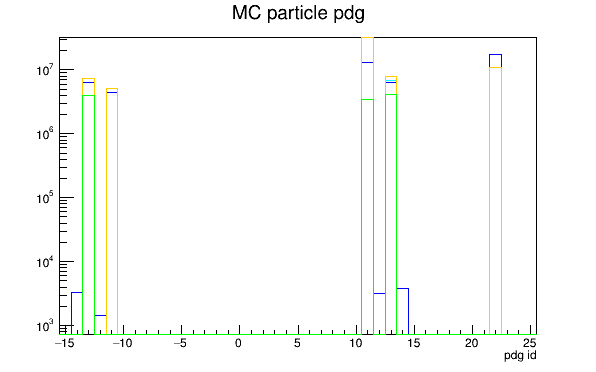

In [7]:
cc1 = R.TCanvas("cc1","CC1",600,400)
cc1.SetLogy()
hh_mc_part_pdg.SetStats(0)
hh_mc_part_pdg.SetLineColor(R.kBlue)
hh_mc_part_pdg.Draw()
hh_clus_pdg.SetLineColor(R.kGreen)
hh_hit_parent_pdg.SetLineColor(R.kCyan)
hh_hit_parent_pdg.Draw("same")
hh_mc_part_pdg.Draw("same")
hh_hit_contrib_pdg.SetLineColor(R.kOrange)
hh_hit_contrib_pdg.Draw("same")
hh_clus_pdg.Draw("same")
cc1.Draw()

Info in <TCanvas::Print>: pdf file Ecal_Cluster_Energy.pdf has been created


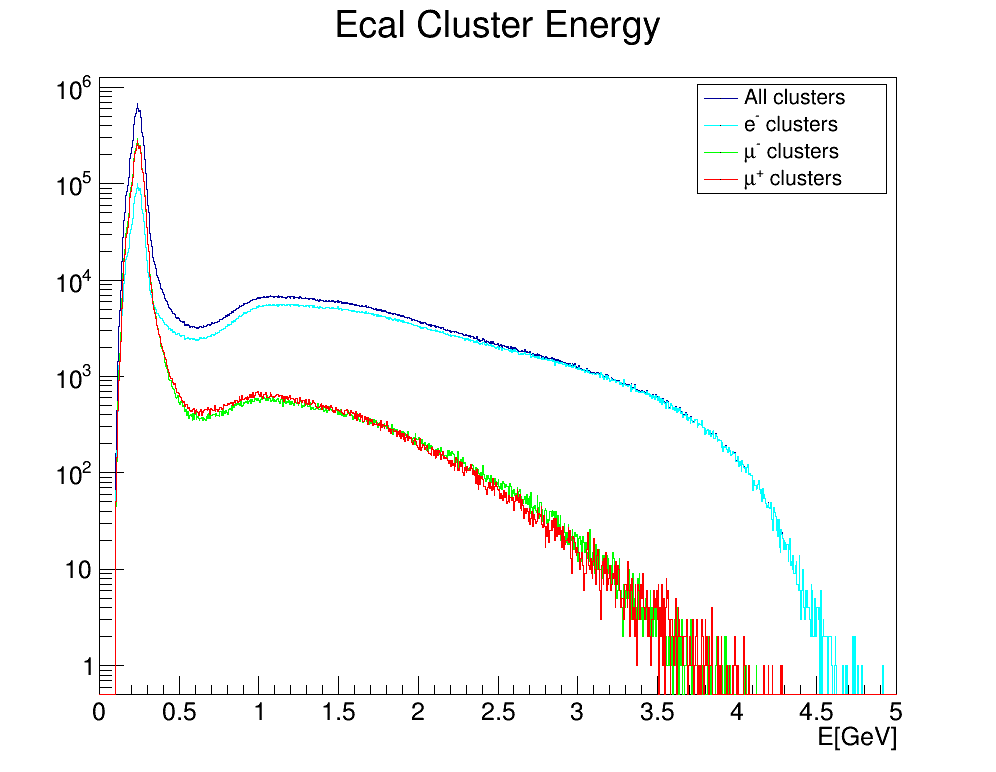

In [8]:
cc2 = R.TCanvas("cc2","CC2",1000,800)
cc2.SetLogy()
hh_clus_e.SetStats(0)
hh_clus_e.Draw()
hh_clus_e_e.SetLineColor(R.kCyan)
hh_clus_e_e.Draw("same")
hh_clus_e_mum.SetLineColor(R.kGreen)
hh_clus_e_mum.Draw("same")
hh_clus_e_mup.SetLineColor(R.kRed)
hh_clus_e_mup.Draw("same")
leg = R.TLegend(0.7,0.75,0.89,0.89)
leg.AddEntry(hh_clus_e.GetPtr(),"All clusters")
leg.AddEntry(hh_clus_e_e.GetPtr(),"e^{-} clusters")
leg.AddEntry(hh_clus_e_mum.GetPtr(),"#mu^{-} clusters")
leg.AddEntry(hh_clus_e_mup.GetPtr(),"#mu^{+} clusters")
leg.Draw()
cc2.Draw()
cc2.SaveAs("Ecal_Cluster_Energy.pdf")

Info in <TCanvas::Print>: pdf file Ecal_Cluster_Energy_One_Hit.pdf has been created


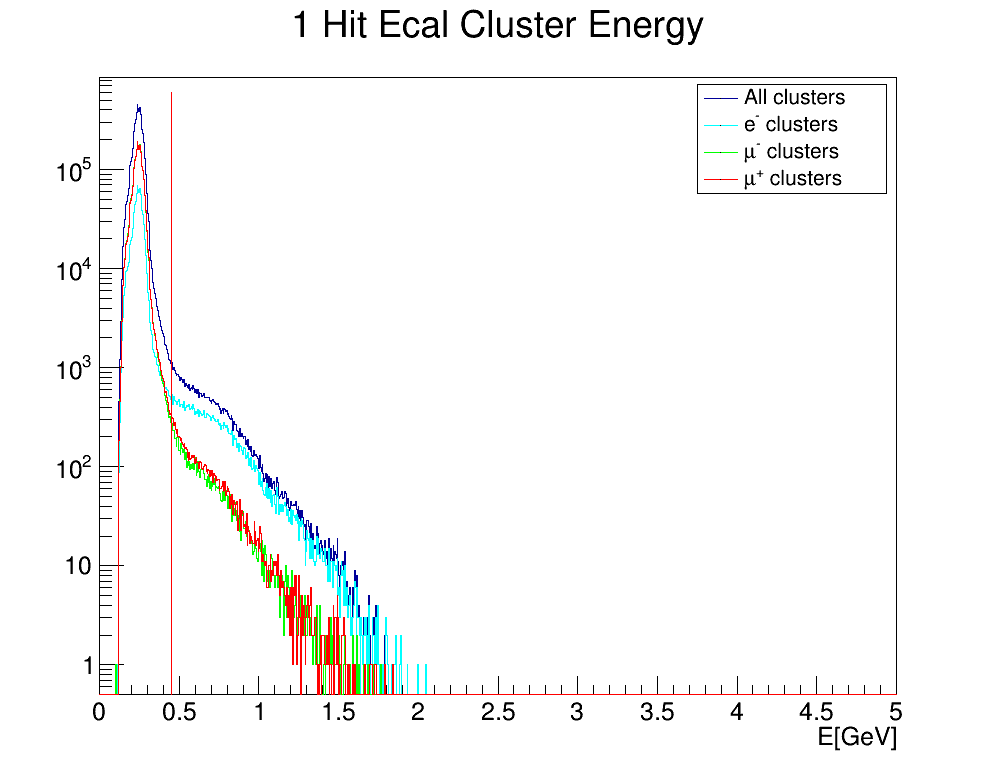

In [9]:
cc3 = R.TCanvas("cc3","CC3",1000,800)
cc3.SetLogy()
hh_clus_e_1h.SetStats(0)
hh_clus_e_1h.Draw()
hh_clus_e_1h_e.SetLineColor(R.kCyan)
hh_clus_e_1h_e.Draw("same")
hh_clus_e_1h_mum.SetLineColor(R.kGreen)
hh_clus_e_1h_mum.Draw("same")
hh_clus_e_1h_mup.SetLineColor(R.kRed)
hh_clus_e_1h_mup.Draw("same")
h_l = R.TLine(0.45,0.,0.45,6e5)
h_l.SetLineColor(R.kRed)
h_l.Draw()
leg = R.TLegend(0.7,0.75,0.89,0.89)
leg.AddEntry(hh_clus_e_1h.GetPtr(),"All clusters")
leg.AddEntry(hh_clus_e_1h_e.GetPtr(),"e^{-} clusters")
leg.AddEntry(hh_clus_e_1h_mum.GetPtr(),"#mu^{-} clusters")
leg.AddEntry(hh_clus_e_1h_mup.GetPtr(),"#mu^{+} clusters")
leg.Draw()
cc3.Draw()
cc3.SaveAs("Ecal_Cluster_Energy_One_Hit.pdf")

In [10]:
print(f"All e-  : {hh_clus_e_e.GetEntries():8.0f} One hit e-  : {hh_clus_e_1h_e.GetEntries():8.0f} = {100*hh_clus_e_1h_e.GetEntries()/hh_clus_e_e.GetEntries():3.3f}%")
print(f"All mu- : {hh_clus_e_mum.GetEntries():8.0f} One hit mu- : {hh_clus_e_1h_mum.GetEntries():8.0f} = {100*hh_clus_e_1h_mum.GetEntries()/hh_clus_e_mum.GetEntries():3.3f}%")
print(f"All mu+ : {hh_clus_e_mup.GetEntries():8.0f} One hit mu+ : {hh_clus_e_1h_mup.GetEntries():8.0f} = {100*hh_clus_e_1h_mup.GetEntries()/hh_clus_e_mup.GetEntries():3.3f}%")

All e-  :  3425248 One hit e-  :   977923 = 28.550%
All mu- :  4087193 One hit mu- :  2523685 = 61.746%
All mu+ :  3910482 One hit mu+ :  2501084 = 63.958%
